In [1]:
# import library
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# create ticker object and fetch historical market data
def ticker_history(comp, start, end):
    ticker = yf.Ticker(comp)
    df = ticker.history(start=start, end=end)
    return df

# split data into training and test data
def train_test_split(df, tSplit, col):
    train = df.loc[:f'{tSplit}', col].values
    test = df.loc[f'{tSplit+1}':, col].values
    return train, test

# standardize training data
def scale_fit_transform(train, scaler):
    train = train.reshape(-1, 1)
    trainStd = scaler.fit_transform(train)
    return trainStd

# convert training data to inputs and outputs
def split_time_series(seq, step):
    X, y = list(), list()
    for i in range(len(seq)):
        end = i + step
        if end > len(seq) - 1:
            break
        xSeq, ySeq = seq[i:end], seq[end]
        X.append(xSeq)
        y.append(ySeq)
    return np.array(X), np.array(y)

# create LSTM model
def lstm_model(step, feature):
    lstm = Sequential()
    lstm.add(LSTM(units=64, activation='tanh', input_shape=(step, feature)))
    lstm.add(Dense(units=1))
    lstm.compile(optimizer='adam', loss='mse')
    return lstm

# transform test data into samples and inverse transform predictions
def lstm_predict(df, test, XTest, yTest, col, lstm, scaler, step, feature):
    dfTot = df.loc[:,col]
    dIn = dfTot[len(dfTot) - len(test) - step :].values
    dIn = dIn.reshape(-1, 1)
    dIn = scaler.transform(dIn)
    XTest, yTest = split_time_series(dIn, step)
    XTest = XTest.reshape(XTest.shape[0], XTest.shape[1], feature)
    yPred = lstm.predict(XTest)
    yPred = scaler.inverse_transform(yPred)
    return XTest, yTest, yPred

In [3]:
comp = ['NVDA', 'AMD']
cols = ['Open', 'High', 'Low', 'Close']
col = cols[1]
start = '2020-12-1'
end = '2024-11-30'
tSplit = 2023
step = 60
feature = 1
nEpoch = 10
nBatch = 32
scaler = MinMaxScaler(feature_range=(0, 1))

In [4]:
# create dataframe
dfNVDA = ticker_history(comp[0], start, end)
dfAMD = ticker_history(comp[1], start, end)

trainNVDA, testNVDA = train_test_split(dfNVDA, tSplit, col)
trainAMD, testAMD = train_test_split(dfAMD, tSplit, col)

trainStdNVDA = scale_fit_transform(trainNVDA, scaler)
trainStdAMD = scale_fit_transform(trainAMD, scaler)

XTrainNVDA, yTrainNVDA = split_time_series(trainStdNVDA, step)
XTrainAMD, yTrainAMD = split_time_series(trainStdAMD, step)

# reshape training data to fit on LSTM model
XTrainNVDA = XTrainNVDA.reshape(XTrainNVDA.shape[0], XTrainNVDA.shape[1], feature)
XTrainAMD = XTrainAMD.reshape(XTrainAMD.shape[0], XTrainAMD.shape[1], feature)

In [5]:
lstmNVDA = lstm_model(step, feature)
lstmAMD = lstm_model(step, feature)

# train the model
lstmNVDA.fit(XTrainNVDA, yTrainNVDA, epochs=nEpoch, batch_size=nBatch)
lstmAMD.fit(XTrainAMD, yTrainAMD, epochs=nEpoch, batch_size=nBatch)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0850
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0058
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0023
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0018
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0015
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1279
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0086
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0063
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0045
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0042
Epoch 6/1

In [6]:
XTestNVDA, yTestNVDA, yPredNVDA = lstm_predict(dfNVDA, testNVDA, XTrainNVDA, yTrainNVDA, col, lstmNVDA, scaler, step, feature)
XTestAMD, yTestAMD, yPredAMD = lstm_predict(dfAMD, testAMD, XTrainAMD, yTrainAMD, col, lstmAMD, scaler, step, feature)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [7]:
import matplotlib.pyplot as plt

In [8]:
def plot_train_test(df, tSplit, col, name):
    df.loc[:f'{tSplit}', col].plot(figsize=(12, 4), legend=True)
    df.loc[f'{tSplit+1}':, col].plot(figsize=(12, 4), legend=True)
    plt.legend([f'Train ( - {tSplit+1})', f'Test ({tSplit+1} - )'])
    plt.title(f'{name} Stock Price')
    plt.show()

def plot_predict(test, predict, name):
    plt.plot(test, label='Real')
    plt.plot(predict, label='Predict')
    plt.title(f'{name} Stock Price Prediction')
    plt.xlabel('Day')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

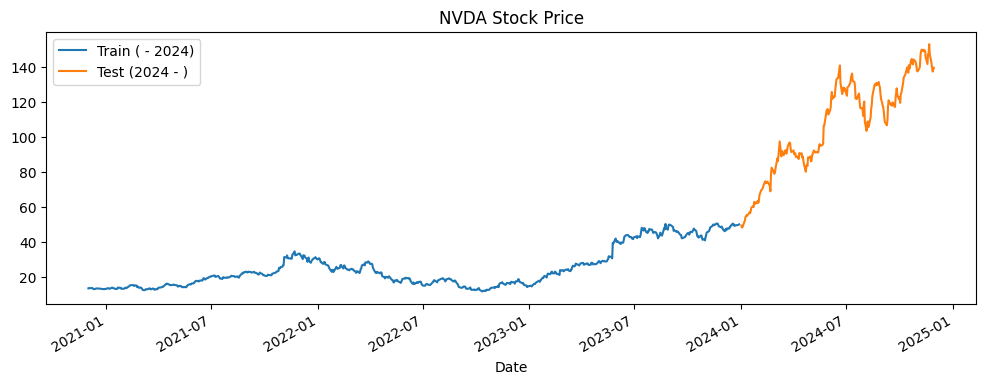

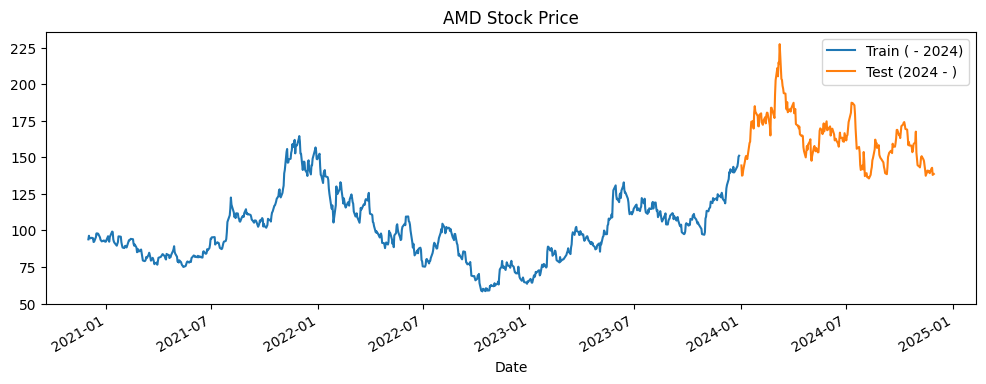

In [9]:
plot_train_test(dfNVDA, tSplit, col, comp[0])
plot_train_test(dfAMD, tSplit, col, comp[1])

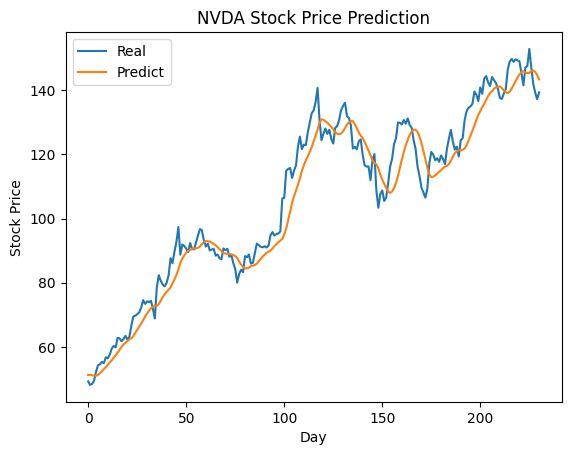

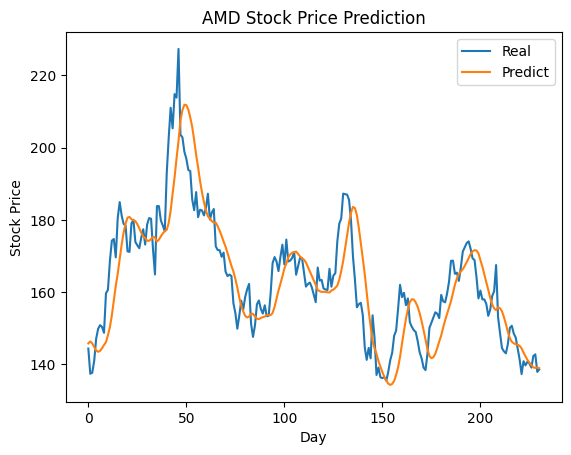

In [10]:
plot_predict(testNVDA, yPredNVDA, comp[0])
plot_predict(testAMD, yPredAMD, comp[1])

In [11]:
print('root mean squared error')
print("NVDA: {}".format(np.sqrt(mean_squared_error(testNVDA, yPredNVDA))))
print("AMD: {}".format(np.sqrt(mean_squared_error(testAMD, yPredAMD))))

root mean squared error
NVDA: 6.251090039641358
AMD: 9.207758958143694


In [12]:
# create dataframe containing date, test and predicted data
dfNVDAout = dfNVDA.loc[f'{tSplit+1}':, col].to_frame()
dfNVDAout['Predict'] = yPredNVDA.reshape(-1)
dfAMDout = dfAMD.loc[f'{tSplit+1}':, col].to_frame()
dfAMDout['Predict'] = yPredAMD.reshape(-1)
# output dataframe
# dfNVDAout.to_csv('nvda_test.csv')
# dfAMDout.to_csv('amd_test.csv')

In [14]:
import seaborn as sns
import json

In [15]:
def create_sentiment_dataframe(file):
    with open(file) as jsondata:
        data = json.load(jsondata)
    sen = pd.DataFrame.from_dict(data, orient='index', columns=['Sentiment']).reset_index()
    sen.rename(columns={'index': 'Date'}, inplace=True)
    sen = sen.set_index('Date')
    sen.index = pd.to_datetime(sen.index).date
    return sen

def join_sentiment_dataframe(df, col, sen):
    dfn = df[[col]].copy()
    dfn.index = dfn.index.date
    dfn = sen.join(dfn, how='inner')
    return dfn

In [16]:
senNVDA = create_sentiment_dataframe('nvidia.json')
senAMD = create_sentiment_dataframe('amd.json')
dfn = join_sentiment_dataframe(dfNVDA, col, senNVDA)
dfa = join_sentiment_dataframe(dfAMD, col, senAMD)
dfna = dfn.join(dfa['High'], how='inner', lsuffix='_NVDA', rsuffix='_AMD')

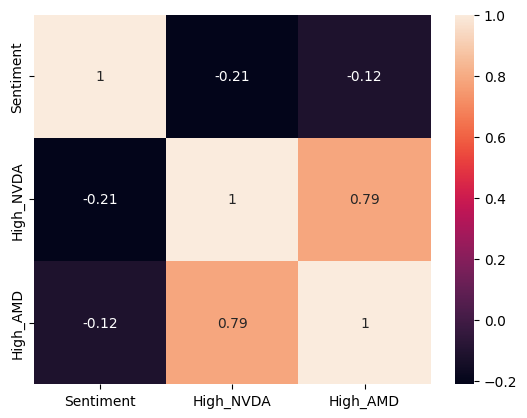

In [17]:
sns.heatmap(dfna.corr(), annot=True)
plt.show()